Survival analysis with python의 코드이다



veteran 데이터셋 설명.

미국 퇴역군인 폐암발병 데이터

trt는 투약유형으로 standard(1)와 test(2)가 있음
celltype 폐암유형  sqaumous-편평세포암, small-소세포 large-대세포 adeno는 비소세포성 폐암

time 치료시작후 생존일수
status는 생존여부 1-사망 0 생존
diagtime은 진단시점?  index 0의 경우 digtime은 진단된지 7개월이라는 얘기
age는 나이
prior는 기치료여부
karno는 카르노프스키 수행척도를 의미  점수가 높을수록 의사능력, 신체능력등의 수준이 높다고 볼수 있다

In [ ]:
import pandas as pd 

veteran_df=pd.read_csv('/content/drive/MyDrive/veteran.csv')
veteran_df.head()

,trt,celltype,time,status,karno,diagtime,age,prior
0,1,squamous,72,1,60,7,69,0
1,1,squamous,411,1,70,5,64,10
2,1,squamous,228,1,60,3,38,0
3,1,squamous,126,1,60,9,63,10
4,1,squamous,118,1,70,11,65,10


In [ ]:
# !pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 10.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=d1e167e9fec01be523455ea867d71fa48f25ff1d944ff58219a288a35ba24ffd
  Stored in directory: /root/.cache/pip/wheels/a8/03/64/8557323821d25118c3a2dc1646996f7a962a8970d4b7d22473
Successfully built autograd-gamma


지수모형 적합(생존시간, status)


In [ ]:
from lifelines import ExponentialFitter
veteran_df_1=veteran_df[veteran_df.trt==1]
epf=ExponentialFitter().fit(veteran_df_1['time'], veteran_df_1['status'])

지수모형 적합한 모형과 위험함수 시각화

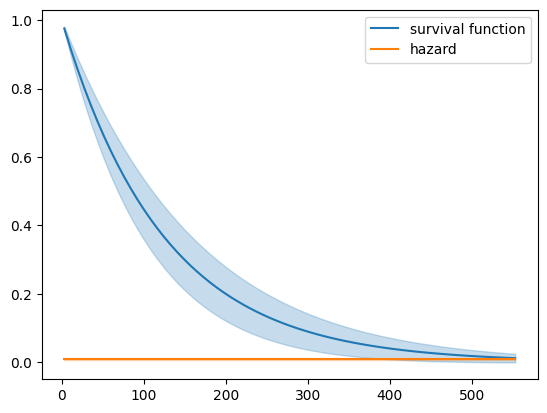

In [ ]:
import matplotlib.pyplot as plt  
epf.plot_survival_function(label='survival function').legend()
epf.plot_hazard(label='hazard').legend()

훈련셋과 테스트셋 분리

In [ ]:
from sklearn.model_selection import train_test_split 
train, test=train_test_split(veteran_df_1)

In [ ]:
trained_epf=ExponentialFitter().fit(train['time'], train['status'])

In [ ]:
estimated_sp=trained_epf.predict(test['time'])
estimated_sp

117    0.391042
22     0.838155
54     0.648329
31     0.779752
72     0.561127
250    0.134488
162    0.272513
100    0.448202
151    0.297663
51     0.664127
228    0.160457
11     0.915508
553    0.011821
42     0.713869
21     0.844908
10     0.922884
122    0.375662
216    0.176678
Name: Exponential_estimate, dtype: float64

브라이어 점수(Brier score)는 전반 적인 수행을 평가하는 척도로 평균 예측 오차에 관한 개념 브라이어 점수는 완벽한 모형에서 0이 나타나는 척 도로 이 값을 구하여 비교한다 0에 가까울수록 좋다

In [ ]:
import math 

def brier_score(actual, estimated):
  n=len(actual)
  error=0.0
  for i in range(n):
    error=error+math.pow(estimated.iloc[i]-actual.iloc[i],2)
  return error/n

계산결과 0.34로 이 점수가 얼마나 좋은건지는 알수없다  폐암데이터임을 감안해야 할듯하다

In [ ]:
brier_score(test['status'],1.0-estimated_sp)

0.3407278465558472

kernel기반 와이불pdf 추정

알아두면 ML/DL 그리고 전통적인 분석 모두 큰도움이 될듯하다

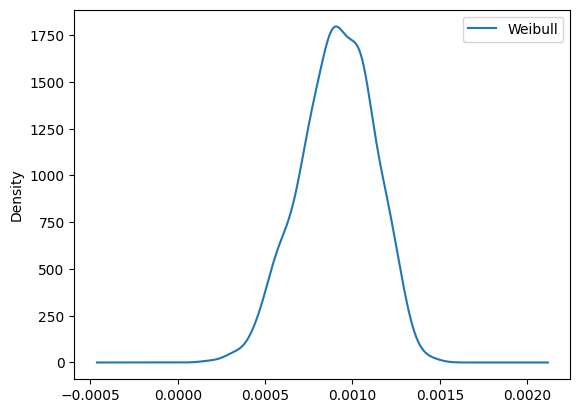

In [ ]:
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import weibull_min

shape=5
scale=0.001
weibull_samples=weibull_min.rvs(shape, 0, scale, size=1000)

pd.DataFrame(weibull_samples).plot(kind='density')
plt.legend(['Weibull'])

스탠포드 심장이식수술 데이터
외국자료라서 최대한 해석
time: 생존시간
status: censoring status  censore 라는 용어는 중도절단이라고 한다 상황에 따라 해석해야 한다
age:연령
t5:  t5 mismatch score 면역거부반응 점수 


In [ ]:
# import pandas as pd

stanford2_df=pd.read_csv('/content/drive/MyDrive/stanford2.csv')
stanford2_df.head()

,id,time,status,age,t5
0,139,86.0,1,12,1.26
1,159,10.0,1,13,1.49
2,181,60.0,0,13,NaN
3,119,1116.0,0,14,0.54
4,74,2006.0,0,15,1.26


와이불 적합이다

In [ ]:
# from sklearn.model_selection import train_test_split
from lifelines import WeibullFitter

train, test=train_test_split(stanford2_df)
wbf=WeibullFitter().fit(train['time'], train['status']) 

와이불 적합후 생존함수 위험함수 시각화

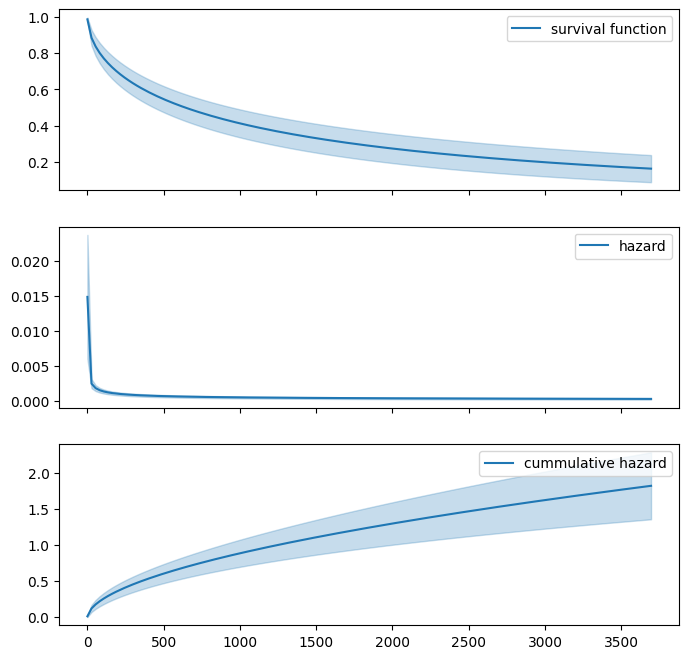

In [ ]:
# import matplotlib.pyplot as plt

fig, axs=plt.subplots(3,figsize=(8,8), sharex=True) 
wbf.plot_survival_function(label='survival function', ax=axs[0]).legend()
wbf.plot_hazard(label='hazard', ax=axs[1]).legend()
wbf.plot_cumulative_hazard(label='cummulative hazard', ax=axs[2]).legend()


In [ ]:
wbf.lambda_,wbf.rho_

(1242.7828308152139, 0.5510436143331822)

In [ ]:
estimated_sp=wbf.predict(test['time'])
brier_score(test['status'], 1.0-estimated_sp)

0.40926460077675647

신뢰구간 함수

In [ ]:
# import math

def compute_confidence_intervals(train, model, estimate_name):
  nu=len(train[train.status==1])
  lower_col=estimate_name+'_lower'
  upper_col=estimate_name+'_upper'
  ci_limits=pd.DataFrame(columns=['time', lower_col, upper_col])
  z=1.96
  for t_i in model.survival_function_.index:
    surv_prob=wbf.survival_function_.loc[t_i, estimate_name]
    ci_limit={}
    ci_limit['time']=t_i
    ci_limit[lower_col]=(math.exp(math.log(surv_prob)*math.exp(z/math.sqrt(nu))))
    ci_limit[upper_col]=(math.exp(math.log(surv_prob)*math.exp(z/math.sqrt(nu))))
    ci_limits=ci_limits.append(ci_limit, ignore_index=True)

  return ci_limits

In [ ]:
compute_confidence_intervals(train, wbf, 'Weibull_estimate').head()

<ipython-input-25-ca2135345530>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ci_limits=ci_limits.append(ci_limit, ignore_index=True)
<ipython-input-25-ca2135345530>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ci_limits=ci_limits.append(ci_limit, ignore_index=True)
<ipython-input-25-ca2135345530>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ci_limits=ci_limits.append(ci_limit, ignore_index=True)
<ipython-input-25-ca2135345530>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ci_limits=ci_limits.append(ci_limit, ignore_index=True)
<ipython-input-25-ca2135345530>:15: FutureWarning: The frame.append method is deprecated and

,time,Weibull_estimate_lower,Weibull_estimate_upper
0,0.500000,0.983512,0.983512
1,27.467153,0.859694,0.859694
2,54.434307,0.802209,0.802209
3,81.401460,0.759499,0.759499
4,108.368613,0.724641,0.724641


검벨분포의 pdf kernel추정

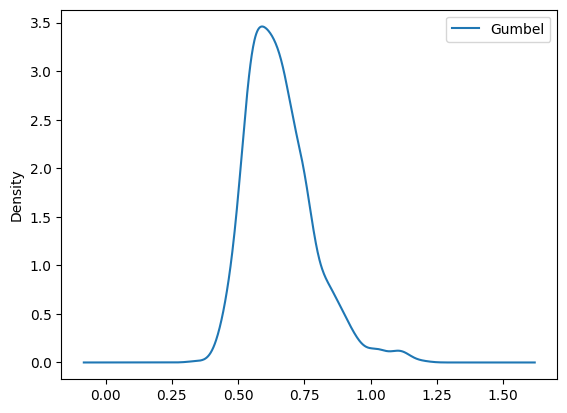

In [ ]:
import numpy as np 
k,rho=0.6, 0.1 

gumbel_samples=np.random.gumbel(k, rho, 1000)

pd.DataFrame(gumbel_samples).plot(kind='density')
plt.legend(['Gumbel'])

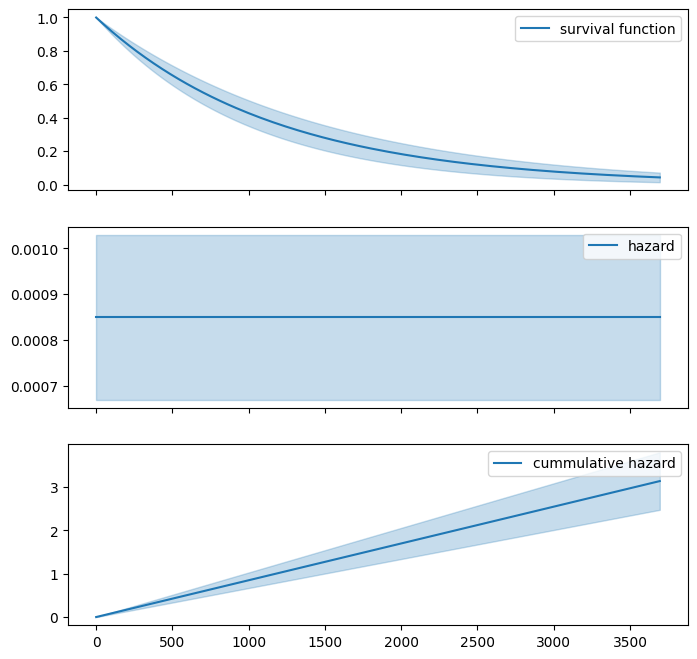

In [ ]:
from lifelines import ExponentialFitter 

exf=ExponentialFitter().fit(train['time'], train['status'])

fig,axs=plt.subplots(3, figsize=(8,8), sharex=True) 
exf.plot_survival_function(label='survival function', ax=axs[0]).legend()
exf.plot_hazard(label='hazard', ax=axs[1]).legend()
exf.plot_cumulative_hazard(label='cummulative hazard', ax=axs[2]).legend()

In [ ]:
exf.lambda_

1176.9593761769645

In [ ]:
wbf.AIC_, exf.AIC_

(1336.7759035823635, 1390.1585990222397)

In [ ]:
import pandas as pd 

stanford2_df=pd.read_csv('/content/drive/MyDrive/stanford2.csv')
stanford2_df.head()

,id,time,status,age,t5
0,139,86.0,1,12,1.26
1,159,10.0,1,13,1.49
2,181,60.0,0,13,NaN
3,119,1116.0,0,14,0.54
4,74,2006.0,0,15,1.26


<Axes: xlabel='time'>

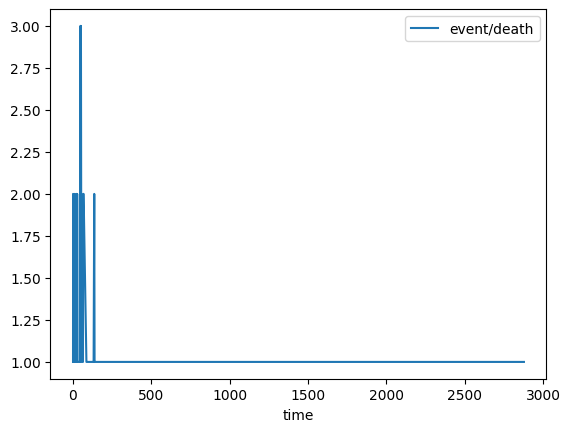

In [ ]:
stanford2_df_sorted=stanford2_df.sort_values(by=['time'])
event_counts=stanford2_df_sorted[stanford2_df_sorted['status']==1].groupby('time').size().reset_index(name='event/death')
event_counts.plot(x='time',y='event/death')

In [ ]:
from lifelines import KaplanMeierFitter

kmft=KaplanMeierFitter()
kmft.fit(stanford2_df_sorted['time'], stanford2_df_sorted['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 184 total observations, 71 right-censored observations>

<Axes: xlabel='timeline'>

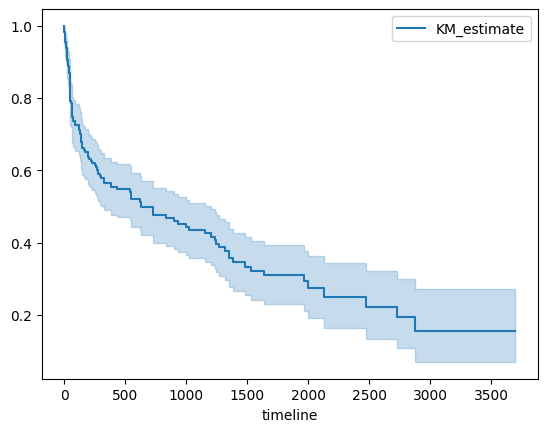

In [ ]:
kmft.plot_survival_function()

In [ ]:
pd.DataFrame(kmft.survival_function_at_times(times=[1.5, 2878.0, 3500.0]))

,KM_estimate
1.5,0.983696
2878.0,0.154919
3500.0,0.154919


In [ ]:
kmft.confidence_interval_survival_function_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
0.5,0.962052,0.999233
1.0,0.950307,0.994712
2.0,0.950307,0.994712
3.0,0.942962,0.991762
...,...,...
2878.0,0.069245,0.271866
2984.0,0.069245,0.271866
3021.0,0.069245,0.271866
3410.0,0.069245,0.271866


In [ ]:
veteran_df_1=veteran_df[veteran_df.trt==1].drop(['trt'], axis=1)
veteran_df_2=veteran_df[veteran_df.trt==2].drop(['trt'], axis=1)

<Axes: xlabel='timeline'>

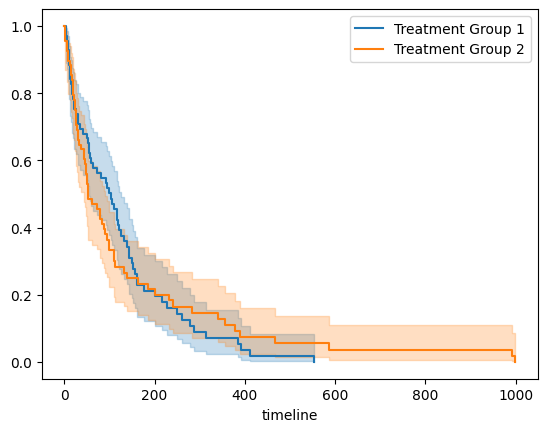

In [ ]:
# from lifelines import KaplanMeierFitter 
kmft_1=KaplanMeierFitter()
kmft_1.fit(veteran_df_1['time'], veteran_df_1['status'], label='Treatment Group 1')

kmft_2=KaplanMeierFitter()
kmft_2.fit(veteran_df_2['time'], veteran_df_2['status'], label='Treatment Group 2')


kmft_1.plot_survival_function()
kmft_2.plot_survival_function()


In [ ]:
veteran_df_sorted=veteran_df.sort_values(by=['time'])
veteran_df_sorted

,trt,celltype,time,status,karno,diagtime,age,prior
76,2,squamous,1,1,20,21,65,10
84,2,squamous,1,1,50,7,35,0
94,2,smallcell,2,1,40,36,44,10
52,1,adeno,3,1,30,3,43,0
17,1,smallcell,4,1,40,2,35,0
...,...,...,...,...,...,...,...,...
82,2,squamous,467,1,90,2,64,0
57,1,large,553,1,70,2,47,0
77,2,squamous,587,1,60,3,58,0
74,2,squamous,991,1,70,7,50,10


In [ ]:
n11=len(veteran_df_1)
n21=len(veteran_df_2)
n11, n21

(69, 68)

In [ ]:
from lifelines.statistics import logrank_test 

results=logrank_test(veteran_df_1['time'], veteran_df_2['time'],
                     veteran_df_1['status'],veteran_df_2['status'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.93      0.11

In [ ]:
veteran_df_1=veteran_df[veteran_df.trt==1].drop(['trt'], axis=1)
veteran_df_1=pd.get_dummies(veteran_df_1, columns=['celltype'])
veteran_df_1.head()

,time,status,karno,diagtime,age,prior,celltype_adeno,celltype_large,celltype_smallcell,celltype_squamous
0,72,1,60,7,69,0,0,0,0,1
1,411,1,70,5,64,10,0,0,0,1
2,228,1,60,3,38,0,0,0,0,1
3,126,1,60,9,63,10,0,0,0,1
4,118,1,70,11,65,10,0,0,0,1


In [ ]:
from lifelines import WeibullAFTFitter 

waft=WeibullAFTFitter(fit_intercept=False).fit(veteran_df_1, duration_col='time', event_col='status')
waft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 69 total observations, 5 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 69
number of events observed = 64
           log-likelihood = -362.85
         time fit was run = 2023-05-09 10:48:18 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                  
lambda_ age                  0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
        celltype_adeno       2.41      11.16       0.99             0.47             4.36                 1.60                77.88
        celltype_large       3.64      38.01       0.96             1.76             5.52                 5.81               248.81
        celltype_smallcell   3.17      23.70       0.94             1.32             5.01                 3.76               149.29
        celltype_squamous    3.57      35.51       0.94             1.73             5.41                 5.65               223.15
        diagtime            -0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
        karno                0.02       1.03       0.01             0.01             0.04                 1.01                 1.04
        prior               -0.04       0.96       0.03            -0.10             0.02                 0.91                 1.02
rho_    Intercept            0.08       1.08       0.09            -0.11             0.27                 0.90                 1.30

                             cmp to     z      p   -log2(p)
param   covariate                                          
lambda_ age                    0.00  0.19   0.85       0.24
        celltype_adeno         0.00  2.43   0.01       6.06
        celltype_large         0.00  3.80 <0.005      12.73
        celltype_smallcell     0.00  3.37 <0.005      10.38
        celltype_squamous      0.00  3.81 <0.005      12.79
        diagtime               0.00 -0.03   0.98       0.03
        karno                  0.00  3.05 <0.005       8.77
        prior                  0.00 -1.40   0.16       2.64
rho_    Intercept              0.00  0.85   0.40       1.33
---
Concordance = 0.69
AIC = 743.69
log-likelihood ratio test = 19.43 on 7 df
-log2(p) of ll-ratio test = 7.17

In [ ]:
estimated_prob_weibull=waft.predict_survival_function(veteran_df_1, times=veteran_df_1['time'])
estimated_prob_weibull.head()

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
72.0,0.698056,0.648711,0.678640,0.565821,0.648564,0.329006,0.381687,0.808691,0.603313,0.760653,...,0.407520,0.813526,0.721699,0.774048,0.860058,0.859014,0.821678,0.810565,0.661153,0.568027
411.0,0.093206,0.057446,0.077370,0.023298,0.057360,0.000650,0.001732,0.246166,0.035584,0.164307,...,0.002669,0.256047,0.116129,0.184375,0.369646,0.366692,0.273466,0.249957,0.065122,0.023904
228.0,0.285586,0.221174,0.258837,0.137321,0.220999,0.020738,0.034806,0.476971,0.171744,0.385272,...,0.043734,0.486988,0.320753,0.409448,0.591203,0.588704,0.504214,0.480836,0.236319,0.139197
126.0,0.517305,0.452236,0.491228,0.351962,0.452048,0.130230,0.170998,0.677492,0.395903,0.605531,...,0.192816,0.684938,0.549886,0.625227,0.758483,0.756795,0.697576,0.680374,0.468268,0.354483
118.0,0.541234,0.477539,0.515778,0.378101,0.477354,0.149778,0.193024,0.695833,0.421887,0.626733,...,0.215867,0.702953,0.572916,0.645699,0.773005,0.771402,0.715026,0.698589,0.493287,0.380623


In [ ]:
estimated_prob_weibull_T=estimated_prob_weibull.T 
estimated_prob_weibull_T=estimated_prob_weibull.T .reset_index(drop=True)
estimated_prob_weibull_T.head()

,72.0,411.0,228.0,126.0,118.0,10.0,82.0,110.0,314.0,100.0,...,12.0,260.0,200.0,156.0,182.0,143.0,105.0,103.0,250.0,100.0
0,0.698056,0.093206,0.285586,0.517305,0.541234,0.958542,0.661101,0.566125,0.169885,0.598624,...,0.949719,0.235781,0.337107,0.435730,0.374660,0.469543,0.582180,0.588711,0.250388,0.598624
1,0.648711,0.057446,0.221174,0.452236,0.477539,0.950300,0.607591,0.504102,0.118343,0.539144,...,0.939779,0.175603,0.270057,0.367820,0.306676,0.402451,0.521364,0.528413,0.188782,0.539144
2,0.678640,0.077370,0.258837,0.491228,0.515778,0.955363,0.639976,0.541406,0.147823,0.574999,...,0.945882,0.210508,0.309535,0.408231,0.346880,0.442498,0.557983,0.564736,0.224606,0.574999
3,0.565821,0.023298,0.137321,0.351962,0.378101,0.935120,0.519105,0.406018,0.060305,0.443559,...,0.921520,0.101363,0.178589,0.268177,0.211117,0.301886,0.424411,0.431978,0.111491,0.443559
4,0.648564,0.057360,0.220999,0.452048,0.477354,0.950275,0.607433,0.503922,0.118211,0.538970,...,0.939749,0.175443,0.269872,0.367628,0.306487,0.402260,0.521186,0.528237,0.188618,0.538970


In [ ]:
# import math
# import numpy as np

def brier_score(actual, estimated):
  n=len(actual)
  total_error=0.0
  for i in range(n):  #iterate for each subject 
    actual_prob=actual['status'].iloc[i]

    #take the computed survival probability for the given time 
    estimated_prob=estimated.iloc[i][actual.iloc[i]['time']]

    if isinstance(estimated_prob, np.float64):
      error=(1.0-estimated_prob)-actual_prob
    else:
      error=(1.0-estimated_prob.iloc[0])-actual_prob 
    total_error=total_error+(error*error)

  return total_error/n

  

In [ ]:
brier_score(veteran_df_1, estimated_prob_weibull_T)

0.35063691339332065

In [ ]:
# import numpy as np 

def compute_baseline_survival_function(df, model, times=None):
  covariates=list(df[df.columns.difference(['time', 'status'])])

  #create a record with all covariate value x as zero 
  X=pd.DataFrame(np.zeros(shape=(1, len(covariates))), columns=covariates)
  return model.predict_survival_function(X, times=times)

In [ ]:
veteran_df_1.iloc[10:11]

,time,status,karno,diagtime,age,prior,celltype_adeno,celltype_large,celltype_smallcell,celltype_squamous
10,42,1,60,4,81,0,0,0,0,1


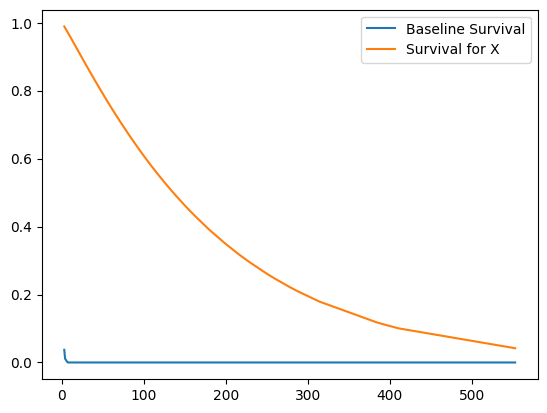

In [ ]:
# import matplotlib.pyplot as plt 

plt.plot(compute_baseline_survival_function(veteran_df_1, waft))
plt.plot(waft.predict_survival_function(veteran_df_1.iloc[10:11]))
plt.legend(['Baseline Survival','Survival for X'])

In [ ]:
veteran_df_1.iloc[59:60]

,time,status,karno,diagtime,age,prior,celltype_adeno,celltype_large,celltype_smallcell,celltype_squamous
59,12,1,40,12,68,10,0,1,0,0


In [ ]:
def compute_risk_score(covariates, w):
  risk_score=0.0 
  for e in list(covariates):
    risk_score=risk_score+(w[('lambda_',e)]*list(covariates[e].values())[0])
  return risk_score

In [ ]:
weights=waft.params_.to_dict()
weights

{('lambda_', 'age'): 0.0023092822740221077,
 ('lambda_', 'celltype_adeno'): 2.4123699786084503,
 ('lambda_', 'celltype_large'): 3.6379434817645238,
 ('lambda_', 'celltype_smallcell'): 3.165353996646138,
 ('lambda_', 'celltype_squamous'): 3.5697115345660864,
 ('lambda_', 'diagtime'): -0.0004652078957940726,
 ('lambda_', 'karno'): 0.02492040580518125,
 ('lambda_', 'prior'): -0.04099003976289917,
 ('rho_', 'Intercept'): 0.08015264014958054}

In [ ]:
import math 

x=veteran_df_1[veteran_df_1.columns.difference(['time', 'status'])].iloc[59:60].to_dict()

t=333.0 
si=math.exp(compute_risk_score(x, weights))
compute_baseline_survival_function(veteran_df_1, model=waft, times=[t*si])



,0
26488.090774,0.0


In [ ]:
waft.predict_survival_function(veteran_df_1.iloc[59:60], times=[t])

,59
333.0,0.008936


In [ ]:
from lifelines import CoxPHFitter 

cxphft=CoxPHFitter(penalizer=0.01).fit(veteran_df_1, duration_col='time', event_col='status')
cxphft.print_summary()


<lifelines.CoxPHFitter: fitted with 69 total observations, 5 right-censored observations>
             duration col = 'time'
                event col = 'status'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 69
number of events observed = 64
   partial log-likelihood = -200.27
         time fit was run = 2023-05-09 11:11:04 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
karno               -0.02       0.98       0.01            -0.04            -0.01                 0.96                 0.99
diagtime             0.01       1.01       0.02            -0.03             0.04                 0.97                 1.05
age                 -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
prior                0.04       1.04       0.03            -0.03             0.10                 0.97                 1.10
celltype_adeno       0.90       2.45       1.47            -1.98             3.77                 0.14                43.44
celltype_large      -0.46       0.63       1.45            -3.30             2.39                 0.04                10.88
celltype_smallcell   0.12       1.12       1.44            -2.71             2.94                 0.07                18.92
celltype_squamous   -0.31       0.73       1.45            -3.15             2.53                 0.04                12.56

                     cmp to     z    p   -log2(p)
covariate                                        
karno                  0.00 -2.76 0.01       7.45
diagtime               0.00  0.26 0.80       0.33
age                    0.00 -0.28 0.78       0.36
prior                  0.00  1.15 0.25       1.99
celltype_adeno         0.00  0.61 0.54       0.88
celltype_large         0.00 -0.31 0.75       0.41
celltype_smallcell     0.00  0.08 0.93       0.10
celltype_squamous      0.00 -0.21 0.83       0.27
---
Concordance = 0.70
Partial AIC = 416.55
log-likelihood ratio test = 18.26 on 8 df
-log2(p) of ll-ratio test = 5.69

In [ ]:
estimated_prob_coxph=cxphft.predict_survival_function(veteran_df_1, times=veteran_df_1['time'])
estimated_prob_coxph_T=estimated_prob_coxph.T
estimated_prob_coxph_T=estimated_prob_coxph_T.reset_index(drop=True)
brier_score(veteran_df_1,estimated_prob_coxph_T)

0.3343834526503375

In [ ]:
weights=cxphft.params_.to_dict()
weights

{'karno': -0.024744311037712987,
 'diagtime': 0.00512189769074788,
 'age': -0.0036442874795349,
 'prior': 0.0361180534365999,
 'celltype_adeno': 0.8951215608501695,
 'celltype_large': -0.4555784905818227,
 'celltype_smallcell': 0.1175433018042618,
 'celltype_squamous': -0.31095398592449625}

In [ ]:
def  compute_risk_score(covariates, w):
  risk_score=0.0 

  for e in list(covariates):
    risk_score=risk_score+(w[e]*list(covariates[e].values())[0])
  return risk_score

In [ ]:
# import math

def compute_hazard_function(model, x, weights):
  si=math.exp(compute_risk_score(x, weights))
  return si*model.baseline_hazard_

In [ ]:
x=veteran_df_1[veteran_df_1.columns.difference(['time', 'status'])].iloc[59:60].to_dict()

In [ ]:
veteran_df_1.iloc[59:60]

,time,status,karno,diagtime,age,prior,celltype_adeno,celltype_large,celltype_smallcell,celltype_squamous
59,12,1,40,12,68,10,0,1,0,0


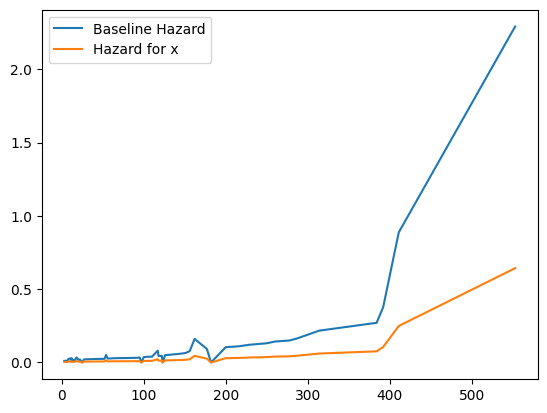

In [ ]:
%matplotlib inline 
# import matplotlib.pyplot as plt

plt.plot(cxphft.baseline_hazard_)
plt.plot(compute_hazard_function(cxphft, x, weights))
plt.legend(['Baseline Hazard', 'Hazard for x'])

In [ ]:
veteran_df_1.iloc[59:61]


,time,status,karno,diagtime,age,prior,celltype_adeno,celltype_large,celltype_smallcell,celltype_squamous
59,12,1,40,12,68,10,0,1,0,0
60,260,1,80,5,45,0,0,1,0,0


In [ ]:
def compute_hazard_ratio(x1,x2,w):
  risk_score_x1=compute_risk_score(x1,w)
  risk_score_x2=compute_risk_score(x2,w)
  return math.exp(risk_score_x1)/math.exp(risk_score_x2)

In [ ]:
x59=veteran_df_1[veteran_df_1.columns.difference(['time', 'status'])].iloc[59:60].to_dict()
x60=veteran_df_1[veteran_df_1.columns.difference(['time', 'status'])].iloc[60:61].to_dict()

In [ ]:
compute_hazard_ratio(x59, x60,weights)

3.680275625760006

In [ ]:
def build_optimal_model_forward_selection(df, time_column, event_column, threshold_p_value):
  current_covariates=[]
  global_set_covariates=list(df[df.columns.difference([time_column, event_column])])
  optimal_model=None

  while True:

    #Get next best covariate by running a combination of models 

    best_covariate, min_p_value, current_optimal_model=_get_next_best_covariate_(X=df,
                                                                                 time_column=time_column,
                                                                                 event_column=event_column,
                                                                                 current_covariates=current_covariates,
                                                                                 remaining_covariates=global_set_covariates)
    #Add to the current set of covariates and remove from global set 
    current_covariates.append(best_covariate)
    global_set_covariates.remove(best_covariate)
    optimal_model=current_optimal_model 

    if min_p_value<=threshold_p_value or len(global_set_covariates)<=0:
      break
  return optimal_model

In [ ]:
import sys 

def _get_next_best_covariate_(X, time_column, event_column, current_covariates=None, remaining_covariates=None):
  min_p_value=sys.float_info.max
  best_covariate=None 
  min_p_model=None

  #Iterate over the set and fit a model with additional covariate 

  for covariate in remaining_covariates:
    covariates=[]
    covariates.extend(current_covariates)
    covariates.append(covariate)
    covariates.append(time_column)
    covariates.append(event_column)

    model=CoxPHFitter(penalizer=0.01).fit(X[covariates], duration_col=time_column, event_col=event_column)

    current_p_value=model.log_likelihood_ratio_test().p_value 

    #Find minimum of the p-values 
    if min_p_value>current_p_value:
      best_covariate=covariate 
      min_p_value=current_p_value 
      min_p_model=model 

  return best_covariate, min_p_value, min_p_model

In [ ]:
optimal_model=build_optimal_model_forward_selection(df=veteran_df_1, time_column='time',
                                                    event_column='status', threshold_p_value=0.00189)
optimal_model.print_summary()

<lifelines.CoxPHFitter: fitted with 69 total observations, 5 right-censored observations>
             duration col = 'time'
                event col = 'status'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 69
number of events observed = 64
   partial log-likelihood = -202.53
         time fit was run = 2023-05-09 11:39:49 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
karno           -0.03       0.97       0.01            -0.04            -0.01                 0.96                 0.99
celltype_adeno   0.98       2.65       0.38             0.22             1.73                 1.25                 5.64

                 cmp to     z      p   -log2(p)
covariate                                      
karno              0.00 -3.38 <0.005      10.42
celltype_adeno     0.00  2.54   0.01       6.48
---
Concordance = 0.66
Partial AIC = 409.05
log-likelihood ratio test = 13.75 on 2 df
-log2(p) of ll-ratio test = 9.92